# Proof splitting

Here we showcase how to split a larger circuit into multiple smaller proofs. This is useful if you want to prove over multiple machines, or if you want to split a proof into multiple parts to reduce the memory requirements.

We showcase how to do this in the case where:
- intermediate calculations need to be kept secret and we need to use the low overhead kzg commitment scheme detailed [here](https://blog.ezkl.xyz/post/commits/) to stitch the circuits together.


First we import the necessary dependencies and set up logging to be as informative as possible. 

In [1]:
# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tf2onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

# make sure you have the dependencies required here already installed
import ezkl
import os
import json
import time
import random
import logging

import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

# uncomment for more descriptive logging 
# FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
# logging.basicConfig(format=FORMAT)
# logging.getLogger().setLevel(logging.INFO)

# Can we build a simple GAN that can produce all 10 mnist digits?

In [2]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = [x/255.0 for x in [x_train, x_test]]
y_train, y_test = [tf.keras.utils.to_categorical(x) for x in [y_train, y_test]]

In [3]:
opt = Adam()
ZDIM = 100

# discriminator
# 0 if it's fake, 1 if it's real
x = in1 = Input((28,28))
x = Reshape((28,28,1))(x)

x = Conv2D(64, (5,5), padding='same', strides=(2,2))(x)
x = BatchNormalization()(x)
x = ELU()(x)

x = Conv2D(128, (5,5), padding='same', strides=(2,2))(x)
x = BatchNormalization()(x)
x = ELU()(x)

x = Flatten()(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = ELU()(x)
x = Dense(1, activation='sigmoid')(x)
dm = Model(in1, x)
dm.compile(opt, 'binary_crossentropy')
dm.summary()

# generator, output digits
x = in1 = Input((ZDIM,))

x = Dense(7*7*64)(x)
x = BatchNormalization()(x)
x = ELU()(x)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(128, (5,5), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ELU()(x)

x = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same')(x)
x = Activation('sigmoid')(x)
x = Reshape((28,28))(x)

gm = Model(in1, x)
gm.compile('adam', 'mse')
gm.summary()

# GAN
dm.trainable = False
x = dm(gm.output)
tm = Model(gm.input, x)
tm.compile(opt, 'binary_crossentropy')

dlosses, glosses = [], []

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization (Batch  (None, 14, 14, 64)        256       
 Normalization)                                                  
                                                                 
 elu (ELU)                   (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                             

   0: dloss:  0.9078   gloss:  1.1653
1/1 [==============================] - 0s 61ms/step


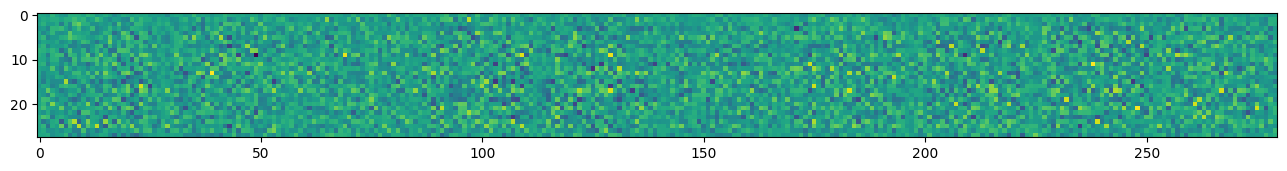

In [4]:
import numpy as np
from matplotlib.pyplot import figure, imshow, show

BS = 256

# GAN training loop
# make larger if you want it to look better
for i in range(1):
  # train discriminator
  dm.trainable = True
  real_i = x_train[np.random.choice(x_train.shape[0], BS)]
  fake_i = gm.predict_on_batch(np.random.normal(0,1,size=(BS,ZDIM)))
  dloss_r = dm.train_on_batch(real_i, np.ones(BS))
  dloss_f = dm.train_on_batch(fake_i, np.zeros(BS))
  dloss = (dloss_r + dloss_f)/2

  # train generator
  dm.trainable = False
  gloss_0 = tm.train_on_batch(np.random.normal(0,1,size=(BS,ZDIM)), np.ones(BS))
  gloss_1 = tm.train_on_batch(np.random.normal(0,1,size=(BS,ZDIM)), np.ones(BS))
  gloss = (gloss_0 + gloss_1)/2

  if i%50 == 0:
    print("%4d: dloss:%8.4f   gloss:%8.4f" % (i, dloss, gloss))
  dlosses.append(dloss)
  glosses.append(gloss)
    
  if i%250 == 0:
    
    figure(figsize=(16,16))
    imshow(np.concatenate(gm.predict(np.random.normal(size=(10,ZDIM))), axis=1))
    show()

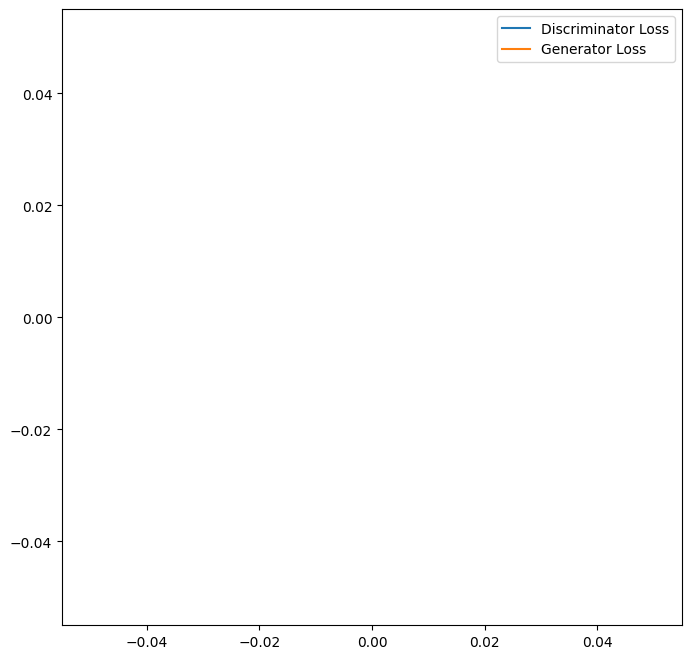

In [5]:
from matplotlib.pyplot import plot, legend
figure(figsize=(8,8))
plot(dlosses[100:], label="Discriminator Loss")
plot(glosses[100:], label="Generator Loss")
legend()

1/1 [==============================] - 0s 14ms/step


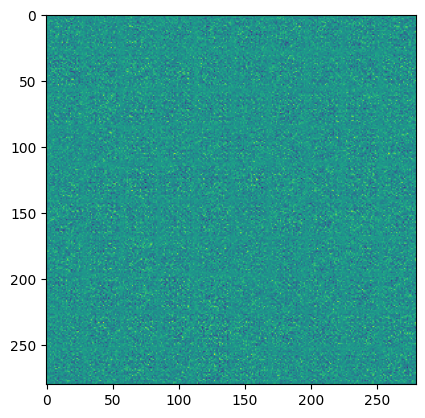

In [6]:
x = []
for i in range(10):
  x.append(np.concatenate(gm.predict(np.random.normal(size=(10,ZDIM))), axis=1))
imshow(np.concatenate(x, axis=0))

Now we export the _generator_ to onnx

In [7]:

import numpy as np
import tf2onnx
import tensorflow as tf
import json

# split the model into 3 parts
gm2 = tf.keras.models.Sequential(gm.layers[0:4])
gm3 = tf.keras.models.Sequential(gm.layers[4:11])
gm4 = tf.keras.models.Sequential(gm.layers[11:])

# After training, export to onnx (network.onnx) and create a data file (input.json)
x = 0.1*np.random.rand(1,*[1, ZDIM])
inter_x1 = gm2(x[0])
inter_x2 = gm3(inter_x1)

output_path = "network_split_0.onnx"
spec = tf.TensorSpec([1, ZDIM], tf.float32, name='input_0')
tf2onnx.convert.from_keras(gm2, input_signature=[spec], inputs_as_nchw=['input_0'], opset=12, output_path=output_path)
output_path = "network_split_1.onnx"
spec = tf.TensorSpec(inter_x1.shape, tf.float32, name='elu1')
tf2onnx.convert.from_keras(gm3, input_signature=[spec], inputs_as_nchw=['input_1'], opset=12, output_path=output_path)
output_path = "network_split_2.onnx"
spec = tf.TensorSpec(inter_x2.shape, tf.float32, name='elu2')
tf2onnx.convert.from_keras(gm4, input_signature=[spec], inputs_as_nchw=['input_2'], opset=12, output_path=output_path)

data_array = x.reshape([-1]).tolist()

data = dict(input_data = [data_array])
inter_x1 = inter_x1.numpy().reshape([-1]).tolist()
inter_x2 = inter_x2.numpy().reshape([-1]).tolist()
data_2 = dict(input_data = [inter_x1])
data_3 = dict(input_data = [inter_x2])

    # Serialize data into file:
data_path = os.path.join('gan_input_0.json')
json.dump( data, open(data_path, 'w' ))
data_path = os.path.join('gan_input_1.json')
json.dump( data_2, open(data_path, 'w' ))
data_path = os.path.join('gan_input_2.json')
json.dump( data_3, open(data_path, 'w' ))



Could not search for non-variable resources. Concrete function internal representation may have changed.
transpose_input for input_0: shape must be rank 4, ignored
Could not search for non-variable resources. Concrete function internal representation may have changed.
Could not search for non-variable resources. Concrete function internal representation may have changed.


###  KZG commitment intermediate calculations

the visibility parameters are:
- `input_visibility`: "kzgcommit"
- `param_visibility`: "public"
- `output_visibility`: kzgcommit

In [8]:
import ezkl

srs_path = os.path.join('kzg.srs')

run_args = ezkl.PyRunArgs()
run_args.input_visibility = "kzgcommit"
run_args.param_visibility = "fixed"
run_args.output_visibility = "kzgcommit"
run_args.variables = [("batch_size", 1)]
run_args.input_scale = 0
run_args.param_scale = 0
run_args.logrows = 9




## Circuit compilation

In [9]:
# iterate over each submodel gen-settings, compile circuit and setup zkSNARK

async def circuit_gen_settings(i):
    # file names
    model_path = os.path.join('network_split_'+str(i)+'.onnx')
    settings_path = os.path.join('settings_split_'+str(i)+'.json')
    data_path =  os.path.join('gan_input_'+str(i)+'.json')

    # generate settings for the current model
    res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)

    res = await ezkl.calibrate_settings(data_path, model_path, settings_path, "resources", scales=[run_args.input_scale])

for i in range(3):
    await circuit_gen_settings(i)


no verifying key provided for kzgcommit. processed value will be none
no verifying key provided for kzgcommit. processed value will be none
no verifying key provided for kzgcommit. processed value will be none
no verifying key provided for kzgcommit. processed value will be none
no verifying key provided for kzgcommit. processed value will be none
no verifying key provided for kzgcommit. processed value will be none
no verifying key provided for kzgcommit. processed value will be none
no verifying key provided for kzgcommit. processed value will be none
no verifying key provided for kzgcommit. processed value will be none
no verifying key provided for kzgcommit. processed value will be none
no verifying key provided for kzgcommit. processed value will be none
no verifying key provided for kzgcommit. processed value will be none
no verifying key provided for kzgcommit. processed value will be none
no verifying key provided for kzgcommit. processed value will be none
no verifying key pro

In [10]:

def get_max_logrows():
    max_logrows = 0
    for i in range(3):
        settings_path = os.path.join('settings_split_'+str(i)+'.json')
        new_settings = json.load(open(settings_path))
        if new_settings["run_args"]['logrows'] > max_logrows:
            max_logrows = new_settings["run_args"]['logrows']
    return max_logrows

def circuit_compiled_model(i, max_lowgrows):
 # now set the next model's input scale to the current model's output scale
    settings_path = os.path.join('settings_split_'+str(i)+'.json')
    model_path = os.path.join('network_split_'+str(i)+'.onnx')
    compiled_model_path = os.path.join('network_split_'+str(i)+'.compiled')
    # compile the circuit
    
    settings = json.load(open(settings_path))
    settings["run_args"]['logrows'] = max_lowgrows
    #  save it
    json.dump(settings, open(settings_path, 'w'))
    
    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True

max_lowgrows = get_max_logrows()
for i in range(3):
    circuit_compiled_model(i, get_max_logrows())

NameError: name 'model_path' is not defined

## Setup phases

In [ ]:
from multiprocessing import Pool

def setup_model(i): 
   compiled_model_path = os.path.join('network_split_'+str(i)+'.compiled')
   pk_path = os.path.join('test_split_'+str(i)+'.pk')
   vk_path = os.path.join('test_split_'+str(i)+'.vk')
      # HERE WE SETUP THE CIRCUIT PARAMS
      # WE GOT KEYS
      # WE GOT CIRCUIT PARAMETERS
      # EVERYTHING ANYONE HAS EVER NEEDED FOR ZK
   res = ezkl.setup(
         compiled_model_path,
         vk_path,
         pk_path,
         srs_path,
      )

   assert res == True
   assert os.path.isfile(vk_path)
   assert os.path.isfile(pk_path)
   
   print("Setup model "+str(i)+" done")
   
for i in range(3): 
    setup_model(i)



spawning module 3


: 

## Sequential witness gen

In [ ]:

def witness_gen_model(i):
      # generate witnesses in sequence
      data_path = os.path.join('input_'+str(i)+'.json')
      witness_path = os.path.join('witness_split_'+str(i)+'.json')
      compiled_model_path = os.path.join('network_split_'+str(i)+'.compiled')
      vk_path = os.path.join('test_split_'+str(i)+'.vk')

      if i > 0:
         prev_witness_path = os.path.join('witness_split_'+str(i-1)+'.json')
         witness = json.load(open(prev_witness_path, 'r'))
         data = dict(input_data = witness['outputs'])
         # Serialize data into file:
         json.dump(data, open(data_path, 'w' ))
      else:
         data_path = os.path.join('gan_input.json')

      res = ezkl.gen_witness(data_path, compiled_model_path, witness_path, vk_path, srs_path)

for i in range(3):
    witness_gen_model(i)

## Proof generation

In [ ]:
# GENERATE A PROOF

def prove_model(i): 
    proof_path = os.path.join('proof_split_'+str(i)+'.json')
    witness_path = os.path.join('witness_split_'+str(i)+'.json')
    compiled_model_path = os.path.join('network_split_'+str(i)+'.compiled')
    pk_path = os.path.join('test_split_'+str(i)+'.pk')
    vk_path = os.path.join('test_split_'+str(i)+'.vk')
    settings_path = os.path.join('settings_split_'+str(i)+'.json')

    res = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,
            srs_path,
            "single",
        )

    print(res)
    assert os.path.isfile(proof_path)

    # Verify the proof
    if i > 0:
        # swap the proof commitments if we are not the first model
        prev_witness_path = os.path.join('witness_split_'+str(i-1)+'.json')
        prev_witness = json.load(open(prev_witness_path, 'r'))

        witness = json.load(open(witness_path, 'r'))

        print(prev_witness["processed_outputs"])
        print(witness["processed_inputs"])

        witness["processed_inputs"] = prev_witness["processed_outputs"]

        # now save the witness
        with open(witness_path, "w") as f:
            json.dump(witness, f)

        res = ezkl.swap_proof_commitments(proof_path, witness_path)

    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path,
            srs_path,
        )

    assert res == True
    print("verified")

for i in range(3):
    prove_model(i)